In [1]:
import anndata as ad
import pandas as pd
import numpy as np
from core.normalize import *
from core.outliers import *
from core.test_model import test_model_from_scratch
from core.kfold_cv import *
from core.annotate import categorize_cogdx


ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

ROSMAP_data = ROSMAP_data.convert_dtypes()
ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

In [2]:
calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', column_name='RELN_metric')
ct_counts_metadata = remove_outliers(ct_counts_metadata, 'RELN_metric', np.percentile(ct_counts_metadata.obs['RELN_metric'], 97))
categorize_cogdx(ct_counts_metadata, {1: 'H', 2: 'M', 3: 'M', 4: 'AD', 5: 'AD', 6: 'O'})
#ct_counts_metadata = ct_counts_metadata[:, ct_counts_metadata.var_names != 'Exc RELN CHD7']

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: invalid value encountered in scalar divide
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: divide by zero encountered in scalar divide
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/annotate.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [3]:
# Hyper parameter classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, RidgeClassifier

AD_filter = (ct_counts_metadata.obs['cogdx_class'] == 'AD') | (ct_counts_metadata.obs['cogdx_class'] == 'H')
X = pd.DataFrame(ct_counts_metadata.X, columns=ct_counts_metadata.var_names, index=ct_counts_metadata.obs_names)[AD_filter]
y = ct_counts_metadata.obs['cogdx_class'][AD_filter].cat.codes

Starting iteration h=RandomForestClassifier(n_estimators=50).......... Done!
Starting iteration h=Lasso().......... Done!
Starting iteration h=RidgeClassifier().......... Done!


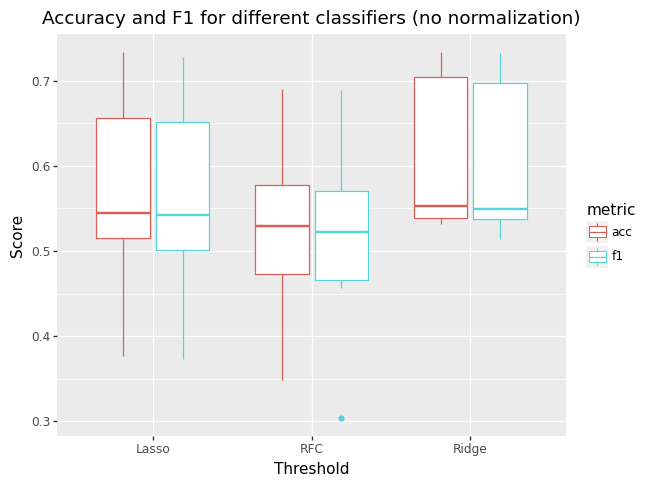

In [4]:
H = [RandomForestClassifier(n_estimators=50),
     Lasso(),
     RidgeClassifier()]
H_mask = ['RFC', 'Lasso', 'Ridge']

def cv_classifiers(X_train, y_train, X_valid, y_valid, h):
    m = h.fit(X_train, y_train)
    pred: np.ndarray = m.predict(X_valid).round(0)

    return {'acc': balanced_accuracy_score(y_valid, pred), 
            'f1': f1_score(y_valid, pred, average='macro')}
    

results = optimize_hyperparam(X, y, 10, H, cv_classifiers, H_mask=H_mask)
plot_optimization_box(results, 'Accuracy and F1 for different classifiers (no normalization)')

In [14]:
res: list[tuple[pd.DataFrame, str]] = []
complete_df: pd.DataFrame
for norm_func, layer in [(normalize_l1, 'l1'),
                         (normalize_l2, 'l2'),
                         (normalize_minmax, 'minmax'),
                         (normalize_robust, 'robust'),
                         (normalize_tmm, 'tmm'),
                         (normalize_mrn, 'mrn')]:
    res.append((test_model_from_scratch(ct_counts_metadata[AD_filter], norm_func, layer, RidgeClassifier(), y=ct_counts_metadata.obs['cogdx_class'][AD_filter].cat.codes), layer))
complete_df = pd.concat([tup[0].assign(_h=tup[1]) for tup in res])

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:15: ImplicitModificationWarning: Setting element `.layers['l1']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:28: ImplicitModificationWarning: Setting element `.layers['l2']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:41: ImplicitModificationWarning: Setting element `.layers['minmax']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:54: ImplicitModificationWarning: Setting element `.layers['robust']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:67: ImplicitModificationWarning: Setting element `.layers['tmm']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:80: ImplicitModificationWarning: Setting element `.layers['mrn']` of view, initializing view as ac

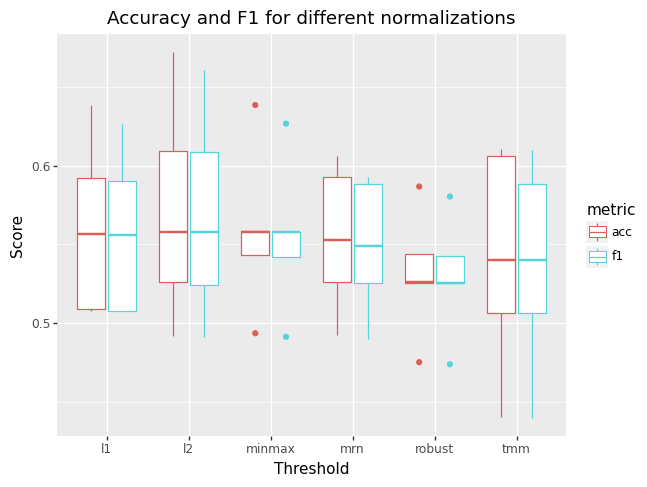

In [15]:
plot_optimization_box(complete_df, 'Accuracy and F1 for different normalizations')